# Canary Models with Seldon and Istio

This folder provides resources to illustrate how to do a canary	roll out of one	MNIST model to another using the canary	pattern where a small amount	of traffic is sent to the new model to validate	it before sending all traffic to the new model.

We utilize two MNIST digit classification models. 

 * Version 1 of the model using scikit-learn
 * Version 2 of the model using Tensorflow.
 
After deploying Istio and Seldon to a kubernetes cluster we will:

 * Deploy version 1 scikit-learn based model using seldon-core
 * Create an istio routing rule to direct all traffic to this version
 * Create a canary deployment with both version 1 and version 2 (the Tensorflow model)
 * Update the istio routing to send 10% of the traffic to version 2
 * Update the istio routing to send 100% of the traffic to version 2
 
 

## Setup

The steps below will install istio and seldon onto a GKE Cluster. If you wish to use your own setup then you need to ensure

 * You allow istio egress to the internet as the load test downloads MNIST images
 * Ensure you give your user cluster-admin privledges
 * Install seldon into a namespace seldon
 
To follow the steps below you will need:
 
  * a Google project running a K8S cluster
  * gcloud and kubectl installed with kubectl authorized for your cluster
  * [istio download](https://github.com/istio/istio/releases/)

## Setup Environment Variables

In [5]:
# Set this to your istio download folder, e.g. 
# %env ISTIO_HOME=~/istio-1.0.0
%env ISTIO_HOME=/home/clive/work/istio/istio-1.0.6

env: ISTIO_HOME=/home/clive/work/istio/istio-1.0.6


In [6]:
# Set this to your GKE Zone for your cluster, e.g.
# %env ZONE=europe-west3-b
%env ZONE=europe-west3-b

env: ZONE=europe-west3-b


In [7]:
# Set this to the GCP Project within which your cluster is running
%env PROJECT=seldon-demos

env: PROJECT=seldon-demos


In [8]:
# Set this to the name of your kubernetes cluster
%env CLUSTER_NAME=istio-seldon

env: CLUSTER_NAME=istio-seldon


## Determine CIDR ranges

In [9]:
!gcloud container clusters describe ${CLUSTER_NAME} --zone ${ZONE} --project ${PROJECT} | grep -e clusterIpv4Cidr -e servicesIpv4Cidr

clusterIpv4Cidr: 10.56.0.0/14
servicesIpv4Cidr: 10.59.240.0/20


## Install Helm

In [10]:
!kubectl create clusterrolebinding my-cluster-admin-binding --clusterrole=cluster-admin --user=$(gcloud info --format="value(config.account)")

clusterrolebinding.rbac.authorization.k8s.io/my-cluster-admin-binding created


In [11]:
!kubectl create -f ${ISTIO_HOME}/install/kubernetes/helm/helm-service-account.yaml

serviceaccount/tiller created
clusterrolebinding.rbac.authorization.k8s.io/tiller created


In [12]:
!helm init --service-account tiller

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


## Install Istio


** Replace the CIDR 10.48.0.0/14\,10.51.240.0/20 values with those you got above **

For more details see [istio docs on egress](https://istio.io/docs/tasks/traffic-management/egress/#calling-external-services-directly)

In [13]:
!helm install ${ISTIO_HOME}/install/kubernetes/helm/istio --name istio --namespace istio-system \
    --set global.proxy.includeIPRanges="10.56.0.0/14\,10.59.240.0/20" --set grafana.enabled=true

NAME:   istio
LAST DEPLOYED: Fri Mar 15 15:05:11 2019
NAMESPACE: istio-system
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/ClusterRoleBinding
NAME                                                    AGE
istio-galley-admin-role-binding-istio-system            58s
istio-ingressgateway-istio-system                       58s
istio-egressgateway-istio-system                        58s
istio-grafana-post-install-role-binding-istio-system    58s
istio-mixer-admin-role-binding-istio-system             58s
istio-pilot-istio-system                                58s
prometheus-istio-system                                 58s
istio-citadel-istio-system                              58s
istio-security-post-install-role-binding-istio-system   58s
istio-sidecar-injector-admin-role-binding-istio-system  58s

==> v1alpha2/prometheus
NAME     AGE
handler  56s

==> v1/Pod(related)
NAME                                     READY  STATUS   RESTARTS  AGE
istio-galley-6c68c5dbcf-kcsxc            1/1    Running  0 

To view the istio Grafana dashboard:
```
kubectl -n istio-system port-forward $(kubectl -n istio-system get pod -l app=grafana -o jsonpath='{.items[0].metadata.name}') 3000:3000
```
http://localhost:3000

## Install Seldon

In [14]:
!kubectl create namespace seldon

namespace/seldon created


In [15]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd

NAME:   seldon-core-crd
LAST DEPLOYED: Fri Mar 15 15:06:41 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  1s


NOTES:
NOTES: TODO




In [16]:
!helm install ../../../helm-charts/seldon-core --name seldon-core --namespace seldon \
    --set ambassador.enabled=true

NAME:   seldon-core
LAST DEPLOYED: Fri Mar 15 15:06:46 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Service
NAME                          TYPE       CLUSTER-IP     EXTERNAL-IP  PORT(S)                        AGE
seldon-core-ambassador        NodePort   10.59.245.46   <none>       80:30123/TCP,443:30357/TCP     1s
seldon-core-ambassador-admin  NodePort   10.59.242.95   <none>       8877:32411/TCP                 1s
seldon-core-seldon-apiserver  NodePort   10.59.252.104  <none>       8080:31488/TCP,5000:31609/TCP  1s
seldon-core-redis             ClusterIP  10.59.240.115  <none>       6379/TCP                       1s

==> v1beta1/Deployment
NAME                                DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-core-ambassador              1        1        1           0          1s
seldon-core-seldon-apiserver        1        1        1           0          1s
seldon-core-seldon-cluster-manager  1        1        1           0          1s
seldon-core-redis

In [17]:
!helm install ../../../helm-charts/seldon-core-analytics --name seldon-core-analytics \
    --set grafana_prom_admin_password=password \
    --set persistence.enabled=false \
    --namespace seldon

NAME:   seldon-core-analytics
LAST DEPLOYED: Fri Mar 15 15:06:51 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Pod(related)
NAME                                      READY  STATUS             RESTARTS  AGE
grafana-prom-import-dashboards-nnd85      0/1    ContainerCreating  0         1s
alertmanager-deployment-5bff7cbb4d-5rr66  0/1    ContainerCreating  0         1s
grafana-prom-deployment-5dbc55b564-nxtxl  0/1    ContainerCreating  0         1s
prometheus-node-exporter-dzh66            0/1    ContainerCreating  0         1s
prometheus-node-exporter-n657d            0/1    Pending            0         1s
prometheus-node-exporter-wpwbf            0/1    ContainerCreating  0         1s
prometheus-deployment-78f855c4b-zpzrb     0/1    ContainerCreating  0         1s

==> v1/Secret
NAME                 TYPE    DATA  AGE
grafana-prom-secret  Opaque  1     1s

==> v1/ServiceAccount
NAME        SECRETS  AGE
prometheus  1        1s

==> v1beta1/ClusterRole
NAME        AGE
prometheu

To send requests to Ambassador ingress in another terminal run:
    
```
kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8002:8080
```

To view the Seldon Grafana dashboard in another terminal run:

```
kubectl port-forward $(kubectl get pods -n seldon -l app=grafana-prom-server -o jsonpath='{.items[0].metadata.name}') -n seldon 3001:3000
```

Use user:admin and the password passed in above in the helm install.

http://localhost:3001/dashboard/db/prediction-analytics?refresh=5s&orgId=1

In [18]:
!kubectl label namespace seldon istio-injection=enabled

namespace/seldon labeled


In [19]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "gke_seldon-demos_europe-west3-b_istio-seldon" modified.


In [20]:
%matplotlib inline
import utils
from visualizer import get_graph
mnist = utils.download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Launch Version 1 Model
A sklearn MNIST model.

In [21]:
!pygmentize mnist_v1.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Mnist classification"
        },
        "name": "mnist-deployment",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/sk-mnist:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "sk-mnist-classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                        ],
 

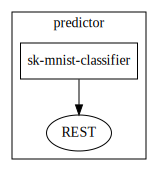

In [22]:
get_graph("mnist_v1.json")

In [52]:
!kubectl apply -f mnist_v1.json

seldondeployment.machinelearning.seldon.io/mnist-classifier created


** Wait until new pods are running **

In [24]:
!kubectl rollout status deploy/mnist-deployment-sk-mnist-predictor-78b83e6

deployment "mnist-deployment-sk-mnist-predictor-78b83e6" successfully rolled out


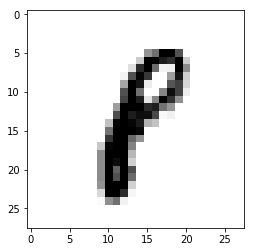

Route:{}
{
  "class:0": "0.00",
  "class:1": "0.03",
  "class:2": "0.00",
  "class:3": "0.00",
  "class:4": "0.03",
  "class:5": "0.03",
  "class:6": "0.07",
  "class:7": "0.00",
  "class:8": "0.83",
  "class:9": "0.00"
}


In [55]:
utils.predict_rest_mnist(mnist,"mnist-classifier")

## Start a Load Test

In [56]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

error: 'role' already has a value (locust), and --overwrite is false


In [57]:
!helm install seldon-core-loadtesting --name loadtest  \
    --namespace seldon \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://mnist-deployment-mnist-classifier:8000 \
    --set oauth.enabled=false \
    --set oauth.key=oauth-key \
    --set oauth.secret=oauth-secret \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Fri Mar 15 15:40:06 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Pod(related)
NAME                   READY  STATUS    RESTARTS  AGE
locust-slave-1-4kptp   0/2    Init:0/1  0         0s
locust-master-1-qd9zg  0/2    Init:0/1  0         0s

==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-slave-1   1        1        0      0s
locust-master-1  1        1        0      0s

==> v1/Service
NAME             TYPE      CLUSTER-IP    EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.59.244.63  <none>       5557:31879/TCP,5558:32461/TCP,8089:31585/TCP  0s




## Setup Version 1 Istio Routing

Just route to version 1 of our model

In [28]:
!pygmentize istio_canary_v1.yaml

apiVersion: networking.istio.io/v1alpha3
kind: VirtualService
metadata:
  name: mnist-deployment
  namespace: seldon
spec:
  hosts:
  - mnist-deployment
  http:
  - route:
    - destination:
        host: mnist-deployment
        subset: v1
---
apiVersion: networking.istio.io/v1alpha3
kind: DestinationRule
metadata:
  name: mnist-deployment
  namespace: seldon  
spec:
  host: mnist-deployment
  subsets:
  - name: v1
    labels:
      version: v1
  - name: v2
    labels:
      version: v2
---


In [64]:
!istioctl create -f istio_canary_v1.yaml

Updated config virtual-service/seldon/mnist-deployment to revision 9948
Updated config destination-rule/seldon/mnist-deployment to revision 9949


## Launch Version 2 of Model

Version 2 is a Tensorflow Deep Learning Model for MNIST. Hopefully, better...

In [58]:
!pygmentize mnist_v2.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Mnist classification"
        },
        "name": "mnist-deployment",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/sk-example-mnist:0.2",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "sk-mnist-classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                    

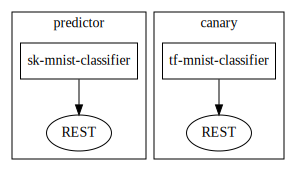

In [59]:
get_graph("mnist_v2.json")

In [60]:
!kubectl apply -f mnist_v2.json

seldondeployment.machinelearning.seldon.io/mnist-classifier configured


** Wait until new pods are running **

In [33]:
!kubectl rollout status deploy/mnist-deployment-tf-mnist-predictor-0b33413

Waiting for deployment "mnist-deployment-tf-mnist-predictor-0b33413" rollout to finish: 0 of 1 updated replicas are available...
deployment "mnist-deployment-tf-mnist-predictor-0b33413" successfully rolled out


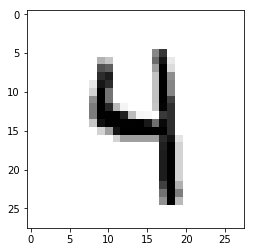

Route:{}
{
  "class:0": "0.00",
  "class:1": "0.00",
  "class:2": "0.00",
  "class:3": "0.01",
  "class:4": "0.95",
  "class:5": "0.01",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.00",
  "class:9": "0.03"
}


In [61]:
utils.predict_rest_mnist(mnist,"mnist-classifier")

## Setup Canary Routing

Let's be cautious and route 30% of traffic to version 2

In [62]:
!pygmentize istio_canary_v2.yaml

apiVersion: networking.istio.io/v1alpha3
kind: VirtualService
metadata:
  name: mnist-deployment
  namespace: seldon
spec:
  hosts:
  - mnist-deployment
  http:
  - route:
    - destination:
        host: mnist-deployment
        subset: v1
      weight: 70
    - destination:
        host: mnist-deployment
        subset: v2
      weight: 30      
---
apiVersion: networking.istio.io/v1alpha3
kind: DestinationRule
metadata:
  name: mnist-deployment
  namespace: seldon  
spec:
  host: mnist-deployment
  subsets:
  - name: v1
    labels:
      version: v1
  - name: v2
    labels:
      version: v2
---


In [65]:
!istioctl replace -f istio_canary_v2.yaml

Updated config virtual-service/seldon/mnist-deployment to revision 11056
Updated config destination-rule/seldon/mnist-deployment to revision 10741


Viewing the Seldon Grafana dashboard we see both models getting traffic.

![dashboard](dashboard.png)

## Setup Routing to Version 2

After testing we are happy and want to switch 100% of traffic to version 2 our Tensorflow model.

In [67]:
!pygmentize istio_canary_v3.yaml

apiVersion: networking.istio.io/v1alpha3
kind: VirtualService
metadata:
  name: mnist-deployment
  namespace: seldon
spec:
  hosts:
  - mnist-deployment-mnist-classifier
  http:
  - route:
    - destination:
        host: mnist-deployment-mnist-classifier
        subset: v2
---
apiVersion: networking.istio.io/v1alpha3
kind: DestinationRule
metadata:
  name: mnist-deployment
  namespace: seldon  
spec:
  host: mnist-deployment-mnist-classifier
  subsets:
  - name: v1
    labels:
      version: v1
  - name: v2
    labels:
      version: v2
---


In [68]:
!istioctl replace -f istio_canary_v3.yaml

Updated config virtual-service/seldon/mnist-deployment to revision 12704
Updated config destination-rule/seldon/mnist-deployment to revision 10741


The dashboard now show traffic 100% to our new model.

![dashboard2](dashboard2.png)

## Switch to final model

Finally, lets save resources and remove version 1 of our model

In [71]:
!pygmentize mnist_v3.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Mnist classification"
        },
        "name": "mnist-deployment",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/tf-example-mnist:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "tf-mnist-classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                    

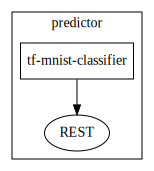

In [72]:
get_graph("mnist_v3.json")

In [73]:
!kubectl apply -f mnist_v3.json

seldondeployment.machinelearning.seldon.io/mnist-classifier configured
